# Visualizations

* run pipeline
* confusion matrices
* feature importance
* shap values
* distribution graphs

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

pd.set_option('display.max_columns', None)
plt.rcParams['figure.facecolor']='w'

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [2]:
test = pd.read_csv('data/test.csv', index_col = 0)
train = pd.read_csv('data/train.csv', index_col = 0)

X_test = test.drop(columns = 'loan_status')
y_test = test.loan_status

X_train = train.drop(columns = 'loan_status')
y_train = train.loan_status



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test_scaled)

In [3]:
X_train.columns


Index(['card_type_classic', 'latest_balance', 'loan_age', 'A14', 'loan_amount',
       'loan_payments', 'card_type_none', 'card_age', 'district_id',
       'n_clients', 'loan_duration', 'account_age', 'total_debit', 'n_orders'],
      dtype='object')

In [4]:
params = {'random_state' : list(range(1,100))}

In [5]:
from sklearn.model_selection import GridSearchCV

In [6]:
gridsearch_tree = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy', 
                                        max_depth=6, max_features = 5, min_samples_split = 0.05, 
                                        splitter = 'best', random_state = 9),
                             params,
                             scoring = 'f1',
                             cv = 5,
                             n_jobs = -1)

In [9]:
tree_model = DecisionTreeClassifier(criterion = 'entropy', 
                                        max_depth=6, max_features = 5, min_samples_split = 0.05, 
                                        splitter = 'best', random_state = 78)

In [10]:
tree_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=78, splitter='best')

## Confusion Matrix

In [11]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

Text(0.5, 1.0, 'Confusion Matrix for Decision Trees')

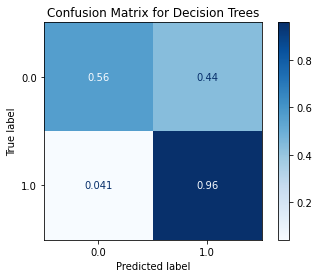

In [12]:
plot_confusion_matrix(tree_model, 
                      X_test_scaled,
                      y_test,
                      cmap= 'Blues', 
                      normalize = 'true')
plt.title('Confusion Matrix for Decision Trees')

Text(0.5, 1.0, 'Confusion Matrix for Decision Trees')

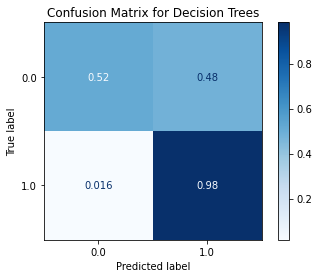

In [13]:
plot_confusion_matrix(tree_model, 
                      X_train_scaled,
                      y_train,
                      cmap= 'Blues', 
                      normalize = 'true')
plt.title('Confusion Matrix for Decision Trees')

## Feature Importance

In [14]:
feature_coef = pd.DataFrame(data=[X_train.columns, tree_model.feature_importances_]).transpose()

In [15]:
top_five_features = feature_coef.sort_values(by=[1], ascending=False)[:4]
top_five_features['Feature'] = ['Latest Balance','# Clients on Account', '# Permanent Orders', 'Set Monthly Payment']

In [39]:
top_five_features[0]

1     latest_balance
9          n_clients
13          n_orders
5      loan_payments
Name: 0, dtype: object

Text(0.5, 1.0, 'Most Important Features in Model')

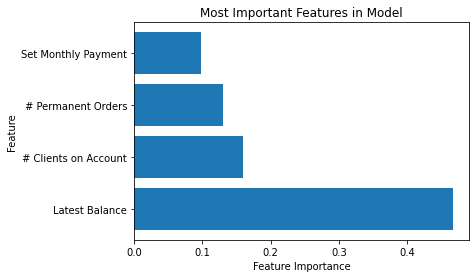

In [17]:



plt.barh(y=top_five_features['Feature'], width = top_five_features[1])

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Most Important Features in Model')

In [18]:
y_test_pred = tree_model.predict(X_test_scaled)

In [19]:
def getscores (true, pred):
    print(f'Recall: {recall_score(true,pred)} \n Precision: {precision_score(true,pred)} \n F1: {f1_score(true,pred)}')

In [20]:
getscores(y_test, y_test_pred)

Recall: 0.9586776859504132 
 Precision: 0.943089430894309 
 F1: 0.9508196721311475


In [21]:
tree_model.score(X_test_scaled, y_test)

0.9124087591240876

## Shap

In [22]:
import shap


In [23]:
explainer = shap.TreeExplainer(tree_model)

shap_values = explainer.shap_values(X_train_scaled)


In [24]:
shap.initjs()

shap.force_plot(base_value = explainer.expected_value[1],
               shap_values = shap_values[1],
               feature_names = X_train.columns)

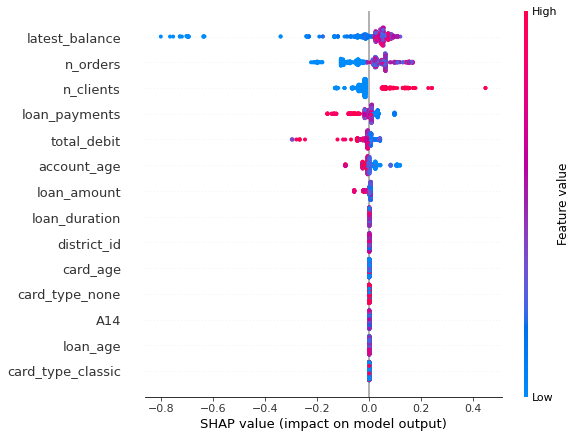

In [25]:
shap.summary_plot(shap_values[1],
                 X_train_scaled,
                 feature_names = X_train.columns)

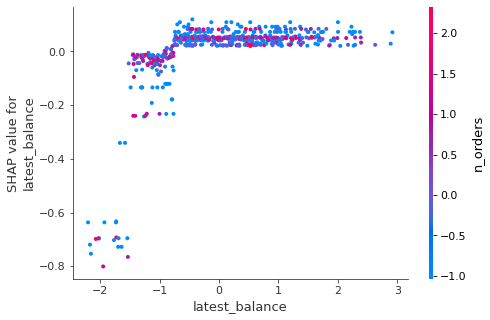

In [26]:
shap.dependence_plot('latest_balance',
                     shap_values[1],
                    X_train_scaled,
                    feature_names = X_train.columns,
                    interaction_index = 'n_orders')

## Distribution Curves

In [27]:
df_all = train.append(test)
df_all.shape, df_all.columns

((682, 15),
 Index(['card_type_classic', 'latest_balance', 'loan_age', 'A14', 'loan_amount',
        'loan_payments', 'card_type_none', 'card_age', 'district_id',
        'n_clients', 'loan_duration', 'loan_status', 'account_age',
        'total_debit', 'n_orders'],
       dtype='object'))

In [28]:
approved = df_all[df_all['loan_status']==1]
rejected = df_all[df_all['loan_status']==0]

In [30]:
import seaborn as sns

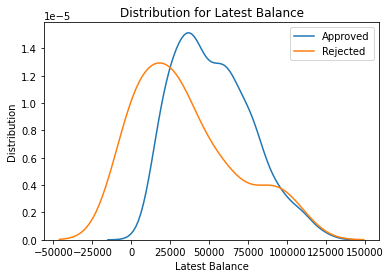

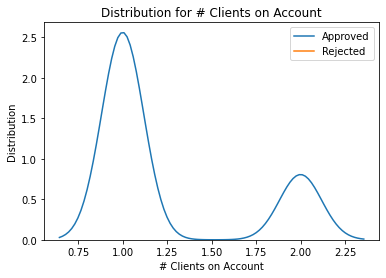

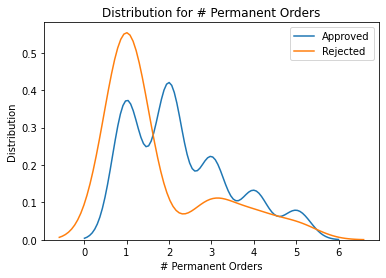

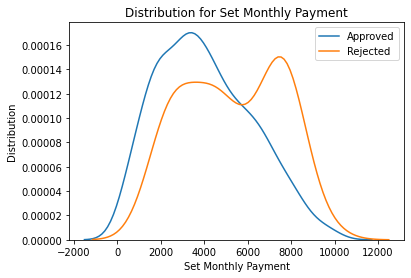

In [40]:
for i,j in zip(top_five_features['Feature'], top_five_features[0]):
    sns.distplot(approved[j], hist = False, label = 'Approved')
    sns.distplot(rejected[j], hist = False, label = 'Rejected')
    plt.xlabel(i)
    plt.ylabel('Distribution')
    plt.title(f'Distribution for {i}')
    plt.show()

Text(0.5, 1.0, 'Number of Clients on Approved vs Rejected Loans')

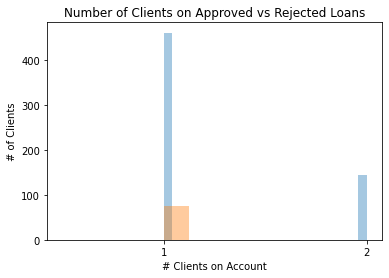

In [75]:
sns.distplot(approved['n_clients'], kde = False, label = 'Approved')
sns.distplot(rejected['n_clients'], kde = False, label = 'Rejected')
plt.xticks(range(1,3))
plt.xlabel('# Clients on Account')
plt.ylabel('# of Clients')
plt.title('Number of Clients on Approved vs Rejected Loans')

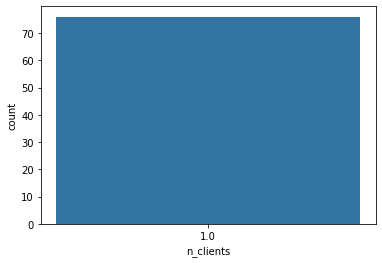

In [71]:
sns.countplot(rejected['n_clients'], label = 'Rejected')

In [76]:
approved['n_clients'].value_counts(), rejected['n_clients'].value_counts()

(1.0    461
 2.0    145
 Name: n_clients, dtype: int64,
 1.0    76
 Name: n_clients, dtype: int64)